# Anastomotic Leakage Prediction
### Phase 1

Taking the existing data manipulation and investigating:
#### 1.1.
* WRS, p value on the leakage vs not leakage for each existing attributes
* Drop patients with missing value for the specific attribute in wrs

#### 1.2.
* If patients have no event data and have 0 on target, remove them

#### 1.3.
* Add categorical data and analyze correlation to target via hypergeometric

#### 1.4.
* Clear data by outlier detection. Look at the stf if its past 3std from the mean on both sides


In [2]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
from datetime import datetime
from datetime import date 
from scipy import stats

import warnings
warnings.filterwarnings("ignore")


In [5]:
COMBINED_DATA_FILE = '../data_files/matrix0_missing_values.xlsx'
# EVENTS = '../data_files/data1.csv'
PATIENTS = '../data_files/anonymous_080620_DA_eg.xlsx'

full_df = pd.read_excel(COMBINED_DATA_FILE, header=[0,1,2,3])[1:]
# events_df = pd.read_csv(EVENTS)
patients_df = pd.read_excel(PATIENTS)

In [6]:
full_df

type metadata                                       \
           time  general                                        
        feature      Sex      Age   Urgency Surgical approach   
      statistic constant constant  constant          constant   
1       1123813     male     59.0  elective              Open   
2       1135541   female     43.0  elective              Open   
3       3918745   female     57.0  elective      Laparoscopic   
4       4894647      NaN      NaN  elective              Open   
5       6541482   female     65.0    urgent              Open   
..          ...      ...      ...       ...               ...   
521  1031926105   female     63.0  elective              Open   
522  1032366104   female     63.0  elective              Open   
523  1033842103     male     61.0  elective              Open   
524  1034462102     male     76.0  elective              Open   
525  1035830101   female     65.0  elective              Open   

                     numeric_events                        ...                \
                     before_surgery                        ... after_surgery   
    Anastomotic Leak        Albumin                        ...       weight    
            constant            max      mean median  min  ...          mean   
1                1.0            4.2  4.200000   4.20  4.2  ...     96.966667   
2                0.0            NaN       NaN    NaN  NaN  ...     68.000000   
3                0.0            3.9  3.900000   3.90  3.9  ...           NaN   
4                0.0            4.3  4.300000   4.30  4.3  ...     71.125000   
5                0.0            3.1  1.942857   1.95  1.4  ...     54.666667   
..               ...            ...       ...    ...  ...  ...           ...   
521              0.0            NaN       NaN    NaN  NaN  ...           NaN   
522              0.0            4.1  4.100000   4.10  4.1  ...     50.500000   
523              1.0            4.8  4.800000   4.80  4.8  ...           NaN   
524              0.0            4.3  4.300000   4.30  4.3  ...           NaN   
525              0.0            3.7  3.700000   3.70  3.7  ...           NaN   

                     drugs                                     \
                  all_days                                      
                 Cefazolin Ceftriaxone Fleet enema Furosemide   
    median   min     count       count       count      count   
1    105.0  85.3       6.0        13.0         1.0       16.0   
2     68.0  68.0       NaN        10.0         NaN        2.0   
3      NaN   NaN       NaN         NaN         NaN        NaN   
4     74.6   0.0       5.0        12.0         1.0       38.0   
5     53.0  53.0       4.0        15.0         NaN      151.0   
..     ...   ...       ...         ...         ...        ...   
521    NaN   NaN       2.0         NaN         1.0        NaN   
522   52.0  46.0       3.0         1.0         2.0        2.0   
523    NaN   NaN       4.0        27.0         1.0        8.0   
524    NaN   NaN       5.0         NaN         1.0        NaN   
525    NaN   NaN       1.0         NaN         1.0        NaN   

                                                 
                                                 
    Magnesium sulfate Meroken new Metronidazole  
                count       count         count  
1                 4.0         1.0          52.0  
2                 NaN         NaN          26.0  
3                 NaN         NaN           NaN  
4                 1.0         1.0          73.0  
5                 7.0         NaN          51.0  
..                ...         ...           ...  
521               NaN         1.0           2.0  
522              24.0         2.0           4.0  
523              13.0         1.0          62.0  
524               2.0         1.0           3.0  
525               1.0         1.0           1.0  

[525 rows x 481 columns]

### 1.1
#### WRS Statistical Significance
We will restructure the data to hold one feature value from the large header and the mean value from all event data.
We will skip NaN values

In [7]:
group_one = full_df.iloc[:, 1:6]
group_one.columns = full_df.columns.get_level_values(2)[1:6]

In [8]:
group_one

,Sex,Age,Urgency,Surgical approach,Anastomotic Leak
1,male,59.0,elective,Open,1.0
2,female,43.0,elective,Open,0.0
3,female,57.0,elective,Laparoscopic,0.0
4,NaN,NaN,elective,Open,0.0
5,female,65.0,urgent,Open,0.0
...,...,...,...,...,...
521,female,63.0,elective,Open,0.0
522,female,63.0,elective,Open,0.0
523,male,61.0,elective,Open,1.0
524,male,76.0,elective,Open,0.0


In [9]:
group_two = full_df.iloc[:,6:-7]

In [10]:
# 4 = Taking the mean from each features
group_two = group_two.iloc[:, 1::4]
group_two.columns = group_two.columns.get_level_values(2)

In [11]:
group_two.shape

(525, 117)

In [12]:
group_two

,Albumin,Alkaline Phosphatase,Amylase,BASO (%),BASO (abs),BMI,"Bilirubin, direct","Bilirubin, total","Calcium, total",Chloride,...,WBC_1,blood pressure,blood pressure diastolic,blood pressure systolic,body temperature,heart rate,height,"respiratory rate, CO2",saturation,weight
1,4.200000,97.0,63.000000,0.500000,0.030000,35.3,0.22,1.500000,9.900000,105.000000,...,7.262093,89.676093,64.431373,120.596026,36.609656,87.566667,174.000000,9.800000,97.169284,96.966667
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.480556,90.180000,51.000000,97.000000,36.745455,87.760000,170.000000,6.647059,97.927711,68.000000
3,3.900000,90.0,53.000000,0.400000,0.040000,38.8,0.06,0.370000,9.800000,102.000000,...,11.616000,115.000000,75.357143,126.851852,35.727778,73.147059,NaN,4.684211,96.787879,NaN
4,4.300000,70.0,NaN,0.300000,0.030000,NaN,NaN,0.360000,9.700000,101.000000,...,5.549455,89.430524,63.564885,114.832000,36.658712,86.694690,168.583333,6.585366,96.739583,71.125000
5,1.942857,94.0,32.692308,0.121429,0.015714,23.6,0.18,0.586429,7.428571,100.142857,...,13.174151,99.845560,76.267176,128.078740,36.910182,89.780980,150.000000,8.125000,97.231970,54.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,NaN,NaN,NaN,NaN,NaN,30.8,NaN,NaN,NaN,NaN,...,5.947778,106.214286,67.270588,121.282353,36.652381,100.649254,NaN,9.593750,97.245455,NaN
522,4.100000,133.0,78.000000,0.600000,0.030000,NaN,0.05,0.260000,9.300000,107.000000,...,4.561719,102.408163,64.205357,119.700000,36.592308,87.720548,151.285714,5.288136,97.741935,50.500000
523,4.800000,89.0,19.000000,0.300000,0.020000,24.7,0.21,1.030000,9.600000,107.000000,...,9.365849,98.692230,71.186441,129.844828,37.121285,87.518519,NaN,11.107143,96.892694,NaN
524,4.300000,92.0,95.000000,0.500000,0.030000,26.6,0.08,0.420000,9.200000,104.000000,...,5.274000,121.948276,58.076923,118.947368,36.175000,74.742424,NaN,11.916667,97.530303,NaN


In [13]:
wrs_data = pd.concat([group_one, group_two], axis=1, sort=False)

In [14]:
wrs_data

,Sex,Age,Urgency,Surgical approach,Anastomotic Leak,Albumin,Alkaline Phosphatase,Amylase,BASO (%),BASO (abs),...,WBC_1,blood pressure,blood pressure diastolic,blood pressure systolic,body temperature,heart rate,height,"respiratory rate, CO2",saturation,weight
1,male,59.0,elective,Open,1.0,4.200000,97.0,63.000000,0.500000,0.030000,...,7.262093,89.676093,64.431373,120.596026,36.609656,87.566667,174.000000,9.800000,97.169284,96.966667
2,female,43.0,elective,Open,0.0,NaN,NaN,NaN,NaN,NaN,...,11.480556,90.180000,51.000000,97.000000,36.745455,87.760000,170.000000,6.647059,97.927711,68.000000
3,female,57.0,elective,Laparoscopic,0.0,3.900000,90.0,53.000000,0.400000,0.040000,...,11.616000,115.000000,75.357143,126.851852,35.727778,73.147059,NaN,4.684211,96.787879,NaN
4,NaN,NaN,elective,Open,0.0,4.300000,70.0,NaN,0.300000,0.030000,...,5.549455,89.430524,63.564885,114.832000,36.658712,86.694690,168.583333,6.585366,96.739583,71.125000
5,female,65.0,urgent,Open,0.0,1.942857,94.0,32.692308,0.121429,0.015714,...,13.174151,99.845560,76.267176,128.078740,36.910182,89.780980,150.000000,8.125000,97.231970,54.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,female,63.0,elective,Open,0.0,NaN,NaN,NaN,NaN,NaN,...,5.947778,106.214286,67.270588,121.282353,36.652381,100.649254,NaN,9.593750,97.245455,NaN
522,female,63.0,elective,Open,0.0,4.100000,133.0,78.000000,0.600000,0.030000,...,4.561719,102.408163,64.205357,119.700000,36.592308,87.720548,151.285714,5.288136,97.741935,50.500000
523,male,61.0,elective,Open,1.0,4.800000,89.0,19.000000,0.300000,0.020000,...,9.365849,98.692230,71.186441,129.844828,37.121285,87.518519,NaN,11.107143,96.892694,NaN
524,male,76.0,elective,Open,0.0,4.300000,92.0,95.000000,0.500000,0.030000,...,5.274000,121.948276,58.076923,118.947368,36.175000,74.742424,NaN,11.916667,97.530303,NaN


Now we will translate catagorical data to numerical values

In [15]:
sex_translator = {
    'female': 0,
    'male': 1
}

urgency_translator = {
    'elective': 0,
    'urgent': 1
}

surgical_approach_translator = {
    'Open': 0,
    'Laparoscopic': 1,
    'Robotic Surgery': 2
}

wrs_data['Sex'] = wrs_data['Sex'].replace(sex_translator)
wrs_data['Urgency'] = wrs_data['Urgency'].replace(urgency_translator)
wrs_data['Surgical approach'] = wrs_data['Surgical approach'].replace(surgical_approach_translator)


In [16]:
def calc_wrs(f):
#     print(f)
    ## defining the two independent samples
    a = f[wrs_data['Anastomotic Leak'] == 0.0].dropna()
    b = f[wrs_data['Anastomotic Leak'] == 1.0].dropna()
    return stats.ranksums(a,b)

wrs_calc_data = wrs_data.apply(calc_wrs, axis=0, result_type="expand")

### The Wilcoxon Rank Sum results are the following:
_For the target value:_

0: statistic - The test statistic under the large-sample approximation that the rank sum statistic is normally distributed.

1: pvalue - The two-sided p-value of the test.


_The p-value is conditional upon the null hypothesis being true is unrelated to the truth or falsity of the research hypothesis. A p-value higher than 0.05 (> 0.05) is not statistically significant and indicates strong evidence for the null hypothesis_

In [17]:
wrs_calc_data

,Sex,Age,Urgency,Surgical approach,Anastomotic Leak,Albumin,Alkaline Phosphatase,Amylase,BASO (%),BASO (abs),...,WBC_1,blood pressure,blood pressure diastolic,blood pressure systolic,body temperature,heart rate,height,"respiratory rate, CO2",saturation,weight
0,-1.290380,-2.707043,-1.153547,4.455240,-1.087240e+01,2.910859,-1.042191,-2.171204,0.864573,0.710674,...,-2.911621,0.378379,-0.156530,1.082072,-4.317991,-4.115627,-0.006677,-0.352159,0.871642,3.108573
1,0.196919,0.006789,0.248686,0.000008,1.560378e-27,0.003604,0.297323,0.029916,0.387273,0.477286,...,0.003596,0.705149,0.875616,0.279220,0.000016,0.000039,0.994673,0.724719,0.383404,0.001880


In [193]:
print("Surgery and Patient Data")
wrs_calc_data.iloc[:, 0:4]

Surgery and Patient Data


,Sex,Age,Urgency,Surgical approach
0,-1.290380,-2.707043,-1.153547,4.455240
1,0.196919,0.006789,0.248686,0.000008


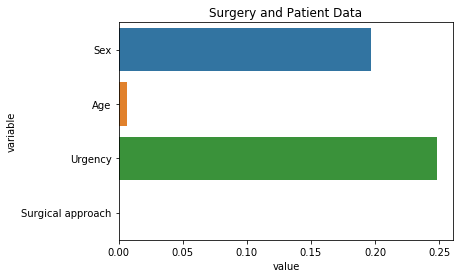

In [201]:
sns.barplot(y = pd.melt(wrs_calc_data.iloc[1:, 0:4]).variable, x = pd.melt(wrs_calc_data.iloc[1:, 0:4]).value)
plt.title("Surgery and Patient Data")
plt.show()

In [202]:
print("Before Surgery") 
wrs_calc_data.iloc[:, 5:58]

Before Surgery


,Albumin,Alkaline Phosphatase,Amylase,BASO (%),BASO (abs),BMI,"Bilirubin, direct","Bilirubin, total","Calcium, total",Chloride,...,SGPT (ALT),Sodium,Urea,WBC_1,blood pressure,body temperature,heart rate,height,saturation,weight
0,2.910859,-1.042191,-2.171204,0.864573,0.710674,3.583689,-2.042350,-1.083652,1.736398,-1.825577,...,-0.103775,0.875854,-1.503132,-0.826703,1.371157,1.628597,-1.542313,-1.276854,0.114627,3.068128
1,0.003604,0.297323,0.029916,0.387273,0.477286,0.000339,0.041117,0.278519,0.082493,0.067914,...,0.917348,0.381110,0.132805,0.408406,0.170326,0.103398,0.122998,0.201654,0.908741,0.002154


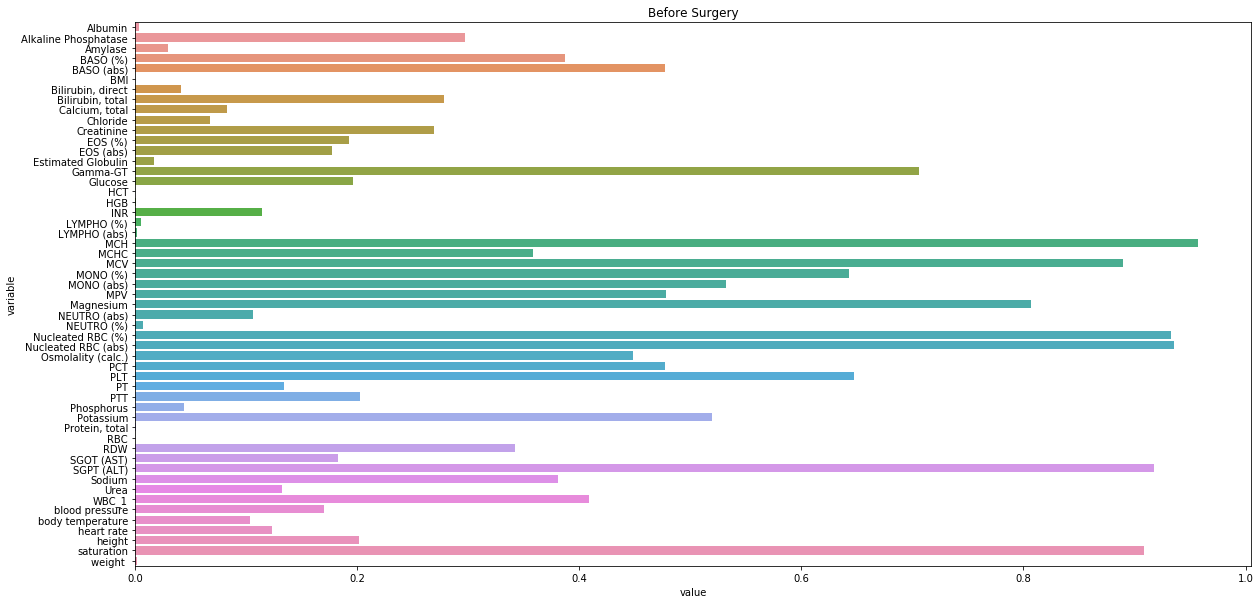

In [204]:
plt.figure(figsize=(20,10))
sns.barplot(y = pd.melt(wrs_calc_data.iloc[1:, 5:58]).variable, x = pd.melt(wrs_calc_data.iloc[1:, 5:58]).value)
plt.title("Before Surgery")
plt.show()

In [188]:
print("After Surgery") 
wrs_calc_data.iloc[:, 58:]

After Surgery


,Albumin,Alkaline Phosphatase,Amylase,BASO (%),BASO (abs),BMI,"Bilirubin, direct","Bilirubin, total","Calcium, total",Chloride,...,WBC_1,blood pressure,blood pressure diastolic,blood pressure systolic,body temperature,heart rate,height,"respiratory rate, CO2",saturation,weight
0,7.056034e+00,-5.199324e+00,-1.009749,0.423469,-0.293957,3.841457,-1.906779,0.061801,4.156101,2.343055,...,-2.911621,0.378379,-0.156530,1.082072,-4.317991,-4.115627,-0.006677,-0.352159,0.871642,3.108573
1,1.713225e-12,2.000146e-07,0.312615,0.671953,0.768791,0.000122,0.056549,0.950722,0.000032,0.019127,...,0.003596,0.705149,0.875616,0.279220,0.000016,0.000039,0.994673,0.724719,0.383404,0.001880


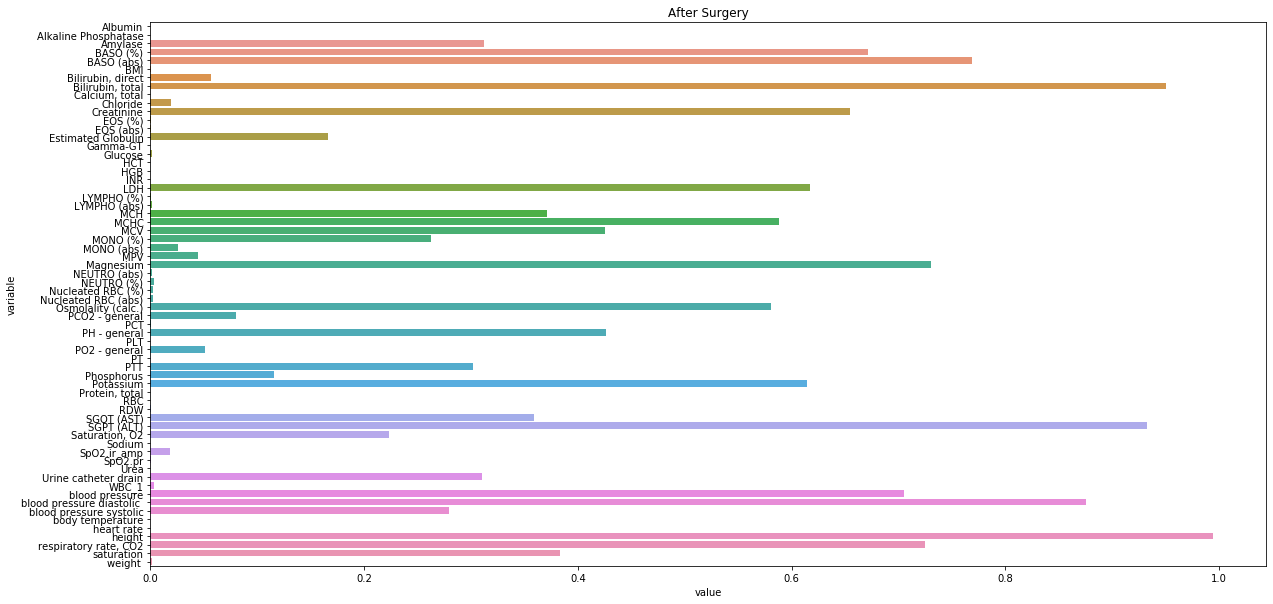

In [208]:
plt.figure(figsize=(20,10))
sns.barplot(y = pd.melt(wrs_calc_data.iloc[1:, 58:]).variable, x = pd.melt(wrs_calc_data.iloc[1:, 58:]).value)
plt.title("After Surgery")
plt.show()

In [185]:
wrs_calc_data.iloc[1:,:][wrs_calc_data.iloc[1:,:] < 0.05]

,Sex,Age,Urgency,Surgical approach,Anastomotic Leak,Albumin,Alkaline Phosphatase,Amylase,BASO (%),BASO (abs),...,WBC_1,blood pressure,blood pressure diastolic,blood pressure systolic,body temperature,heart rate,height,"respiratory rate, CO2",saturation,weight
1,NaN,0.006789,NaN,0.000008,1.560378e-27,0.003604,NaN,0.029916,NaN,NaN,...,0.003596,NaN,NaN,NaN,0.000016,0.000039,NaN,NaN,NaN,0.00188


### 1.2.
#### Removing partient that have no events AND target is without AL

In [81]:
full_df

type metadata                                       \
           time  general                                        
        feature      Sex      Age   Urgency Surgical approach   
      statistic constant constant  constant          constant   
1       1123813     male     59.0  elective              Open   
2       1135541   female     43.0  elective              Open   
3       3918745   female     57.0  elective      Laparoscopic   
4       4894647      NaN      NaN  elective              Open   
5       6541482   female     65.0    urgent              Open   
..          ...      ...      ...       ...               ...   
521  1031926105   female     63.0  elective              Open   
522  1032366104   female     63.0  elective              Open   
523  1033842103     male     61.0  elective              Open   
524  1034462102     male     76.0  elective              Open   
525  1035830101   female     65.0  elective              Open   

                     numeric_events                        ...                \
                     before_surgery                        ... after_surgery   
    Anastomotic Leak        Albumin                        ...       weight    
            constant            max      mean median  min  ...          mean   
1                1.0            4.2  4.200000   4.20  4.2  ...     96.966667   
2                0.0            NaN       NaN    NaN  NaN  ...     68.000000   
3                0.0            3.9  3.900000   3.90  3.9  ...           NaN   
4                0.0            4.3  4.300000   4.30  4.3  ...     71.125000   
5                0.0            3.1  1.942857   1.95  1.4  ...     54.666667   
..               ...            ...       ...    ...  ...  ...           ...   
521              0.0            NaN       NaN    NaN  NaN  ...           NaN   
522              0.0            4.1  4.100000   4.10  4.1  ...     50.500000   
523              1.0            4.8  4.800000   4.80  4.8  ...           NaN   
524              0.0            4.3  4.300000   4.30  4.3  ...           NaN   
525              0.0            3.7  3.700000   3.70  3.7  ...           NaN   

                     drugs                                     \
                  all_days                                      
                 Cefazolin Ceftriaxone Fleet enema Furosemide   
    median   min     count       count       count      count   
1    105.0  85.3       6.0        13.0         1.0       16.0   
2     68.0  68.0       NaN        10.0         NaN        2.0   
3      NaN   NaN       NaN         NaN         NaN        NaN   
4     74.6   0.0       5.0        12.0         1.0       38.0   
5     53.0  53.0       4.0        15.0         NaN      151.0   
..     ...   ...       ...         ...         ...        ...   
521    NaN   NaN       2.0         NaN         1.0        NaN   
522   52.0  46.0       3.0         1.0         2.0        2.0   
523    NaN   NaN       4.0        27.0         1.0        8.0   
524    NaN   NaN       5.0         NaN         1.0        NaN   
525    NaN   NaN       1.0         NaN         1.0        NaN   

                                                 
                                                 
    Magnesium sulfate Meroken new Metronidazole  
                count       count         count  
1                 4.0         1.0          52.0  
2                 NaN         NaN          26.0  
3                 NaN         NaN           NaN  
4                 1.0         1.0          73.0  
5                 7.0         NaN          51.0  
..                ...         ...           ...  
521               NaN         1.0           2.0  
522              24.0         2.0           4.0  
523              13.0         1.0          62.0  
524               2.0         1.0           3.0  
525               1.0         1.0           1.0  

[521 rows x 481 columns]

In [351]:
full_df.isnull().sum(axis=1)

1        0
2      216
3       27
4       26
5        2
      ... 
521    199
522      4
523      8
524     14
525     14
Length: 525, dtype: int64

In [158]:
patient_with_enough_events = full_df.dropna(axis = 0, how = all ,thresh=300)

In [159]:
patient_with_enough_events.isnull().sum(axis=1)

1       0
3      27
4      26
5       2
7       4
       ..
520    11
522     4
523     8
524    14
525    14
Length: 352, dtype: int64

In [160]:
patient_with_enough_events

type metadata                                       \
           time  general                                        
        feature      Sex      Age   Urgency Surgical approach   
      statistic constant constant  constant          constant   
1       1123813     male     59.0  elective              Open   
3       3918745   female     57.0  elective      Laparoscopic   
4       4894647      NaN      NaN  elective              Open   
5       6541482   female     65.0    urgent              Open   
7      10766460   female     18.0  elective              Open   
..          ...      ...      ...       ...               ...   
520  1030904106      NaN      NaN  elective              Open   
522  1032366104   female     63.0  elective              Open   
523  1033842103     male     61.0  elective              Open   
524  1034462102     male     76.0  elective              Open   
525  1035830101   female     65.0  elective              Open   

                     numeric_events                        ...                \
                     before_surgery                        ... after_surgery   
    Anastomotic Leak        Albumin                        ...       weight    
            constant            max      mean median  min  ...          mean   
1                1.0            4.2  4.200000   4.20  4.2  ...     96.966667   
3                0.0            3.9  3.900000   3.90  3.9  ...           NaN   
4                0.0            4.3  4.300000   4.30  4.3  ...     71.125000   
5                0.0            3.1  1.942857   1.95  1.4  ...     54.666667   
7                0.0            4.4  3.940000   3.90  3.7  ...     56.450000   
..               ...            ...       ...    ...  ...  ...           ...   
520              0.0            4.7  4.700000   4.70  4.7  ...     68.000000   
522              0.0            4.1  4.100000   4.10  4.1  ...     50.500000   
523              1.0            4.8  4.800000   4.80  4.8  ...           NaN   
524              0.0            4.3  4.300000   4.30  4.3  ...           NaN   
525              0.0            3.7  3.700000   3.70  3.7  ...           NaN   

                     drugs                                     \
                  all_days                                      
                 Cefazolin Ceftriaxone Fleet enema Furosemide   
    median   min     count       count       count      count   
1    105.0  85.3       6.0        13.0         1.0       16.0   
3      NaN   NaN       NaN         NaN         NaN        NaN   
4     74.6   0.0       5.0        12.0         1.0       38.0   
5     53.0  53.0       4.0        15.0         NaN      151.0   
7     57.0  54.8       NaN         NaN         1.0        NaN   
..     ...   ...       ...         ...         ...        ...   
520   68.0  68.0       1.0         1.0         1.0        NaN   
522   52.0  46.0       3.0         1.0         2.0        2.0   
523    NaN   NaN       4.0        27.0         1.0        8.0   
524    NaN   NaN       5.0         NaN         1.0        NaN   
525    NaN   NaN       1.0         NaN         1.0        NaN   

                                                 
                                                 
    Magnesium sulfate Meroken new Metronidazole  
                count       count         count  
1                 4.0         1.0          52.0  
3                 NaN         NaN           NaN  
4                 1.0         1.0          73.0  
5                 7.0         NaN          51.0  
7                 2.0         2.0           NaN  
..                ...         ...           ...  
520               4.0         1.0           6.0  
522              24.0         2.0           4.0  
523              13.0         1.0          62.0  
524               2.0         1.0           3.0  
525               1.0         1.0           1.0  

[352 rows x 481 columns]

In [359]:
RESULT_PATH = 'patient_with_enough_events.xlsx'
patient_missing_events.to_excel(RESULT_PATH)